In [1]:
from __future__ import division
import numpy as np
from numpy.random import choice, normal, multivariate_normal
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import glob
%matplotlib inline
import csv
def read_data(file_path):
    # The read-in data should be a N*W matrix,
    # where N is the length of the time sequences,
    # W is the number of sensors/data features
    i = 0
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter = ',')
        for line in reader:
            line = np.array(line, dtype = 'float') # str2float
            if i == 0:
                data = line
            else:
                data = np.vstack((data, line))
            i += 1
    return data

In [2]:
'''
Load the segments where a continuous obs car exists
'''
data_path = "drive_segments/*.csv"
files = glob.glob(data_path)
all_segs = []
for name in files:
    data = read_data(name)#[frame_id, x_obs,y_obs,dv,a_obs]
    data[:,0] += 1149 # change the 
    all_segs.append(data)
'''
load the ego car data
'''
ego_data_path = "ego_data_24d.csv"
ego_data = read_data(ego_data_path)
ego_lane = ego_data[:,[18,19,15,16,20,21,22,23]]
ego_data = ego_data[:,[0,9,17,14,18,19]] # x_dot_ego ,accel_x, psi_T_0, r_rate, left_dist, right_dist
'''
Load the MRM result
'''
data_name='MRM_result.pkl'
MRM_results = pkl.load(open(data_name, 'rb'))

In [3]:
'''
match obs car data segments with ego car data
'''
num_actions = 3
data_segments = []
for segment in all_segs:
    ego_lane_list = []
    ego_car_list = []
    ego_prob_list = []
    obs_prob_list = []
    violation_prob_list = []
    for i, MRM in enumerate(MRM_results):
        if MRM['frame_id'] < 1150: # skip parking lot
            continue
        if MRM['frame_id']+1 in segment[:,0]:
            # read ego car data
            ego_lane_data = ego_lane[MRM['frame_id'],:]
            ego_car_data = ego_data[MRM['frame_id'],:]
            matched_obs_idx = np.where(MRM['obs_id'] == segment[0,1])[0]
            ego_action_prob = np.reshape(MRM['ego_probs'], (num_actions,))
            obs_action_prob = np.reshape(MRM['obs_probs'][:,matched_obs_idx], (num_actions,))#matched_obs_idx*3:(matched_obs_idx+1)*3
            violation_prob = np.reshape(MRM['violation_prob'][:,matched_obs_idx,:], (num_actions, num_actions))

            # save to list
            ego_lane_list.append(ego_lane_data)
            ego_car_list.append(ego_car_data)
            ego_prob_list.append(ego_action_prob)
            obs_prob_list.append(obs_action_prob)
            violation_prob_list.append(violation_prob)
    ego_lane_list = np.array(ego_lane_list)
    ego_car_list = np.array(ego_car_list)
    ego_prob_list = np.array(ego_prob_list)        
    obs_prob_list = np.array(obs_prob_list)
    violation_prob_list = np.array(violation_prob_list)
    
    concat_seg = np.hstack([segment[:,3:7],ego_car_list])
    data_segments.append(concat_seg)


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
class GMM_HMM():
    def __init__(self,num_seq,data,M=3,K=10,model='Gaussian',kmeans_init=False):
        self.K = K # number of hidden states
        self.M = M # number of modes of Gaussian mixture model for each state
        self.data = data # all segments
        self.num_seq = num_seq # number of sequences used to train
        self.model = model # observation model, Gaussian or GMM

        # initial prior of states
        self.pi0 = np.ones(self.K)*1/self.K # first state prior, a (K,) array
        #
        if num_seq > 1:
            self.n, self.d = data[0].shape
            len_seq = self.data[0].shape[0] # length of each data sequence
            self.ravel_data = self.data[0] # reshape multiple sequences in to a long sequence for GMM only
            for i , data in enumerate(self.data):
                if i > 0:
                    self.ravel_data = np.vstack([self.ravel_data,data])
                    len_seq = np.append(len_seq, data.shape[0])
        
        if kmeans_init:
            self.state = kmeans2(self.ravel_data, self.K)[1]
        else:
            self.state = choice(self.K, self.ravel_data.shape[0])
        if self.model == 'Gaussian' or 'GMM':
            # compute parameter for each cluster
            self.mu = []
            self.sigma = []
            for k in range(self.K):
                idx = np.where(self.state==k)[0] # multi variable
                nc = len(idx)
                if nc:# multi variable
                    cluster = np.reshape(self.ravel_data[idx,:],(nc,self.d))
                    self.mu.append(np.mean(cluster,0)) # multi variable
                    if nc > 1:
                        self.sigma.append(np.cov(cluster,rowvar=False)) # multi variable
                    else:
                        self.sigma.append(np.eye(self.d))
                else:
                    cluster = []
                    self.mu.append(multivariate_normal(np.zeros(self.d), np.eye(self.d))) # multi variable
                    self.sigma.append(np.eye(self.d)) # multi variable
        
        # transition model 
        self.N = np.zeros((self.K, self.K))
        ctr = 0
        for i  in range(num_seq):
            self.data[i].shape[0]
            ctr += 1
            for n in range(1, len_seq[i]):
                self.N[self.state[ctr-1], self.state[ctr]] += 1
                ctr += 1
        self.A = (self.N.T/(np.sum(self.N, axis=1)+1e-7)).T
                
        if self.model == 'GMM':
            self.omega = np.ones(self.K) * 1/self.K
            
        self.xi_list = []
        self.gamma_list = []
        self.p_list = []
        self.log_like_matrix_list = []
        
    def train(self,num_iter,converge_thresh):
        prevQ = -1e20
        i = 0
        while i < num_iter:
            gamma_list = []
            xi_list = []
            p_list = []
            log_like_matrix_list = [] 
            for j, segment in enumerate(self.data):
                log_like_matrix = self.log_likelihood_matrix(segment)
                alpha,beta = self.forward_backward_algorithm(segment,log_like_matrix)
                gamma, xi, P = self.E_step(alpha,beta,segment,log_like_matrix)

                gamma_list.append(gamma)
                xi_list.append(xi)
                p_list.append(P)
                log_like_matrix_list.append(log_like_matrix)
                
            Q = self.check_log_likelihood(gamma_list, xi_list, log_like_matrix_list)

            self.M_step(gamma_list, xi_list, p_list)
            
            print ('log-likelihood: ', Q)
            if Q < prevQ:
                print('warning: the log-likelihood is decreasing')
            if abs(Q - prevQ) < converge_thresh:
                print('THe log-likelihood converges')
                return
            prevQ = Q
            i += 1
            
    def forward_backward_algorithm(self, data, log_like_matrix):
        # forward
        T = data.shape[0]
        alpha = np.zeros((T, self.K))
        alpha[0, :] = self.pi0*np.exp(log_like_matrix[0,:])#1
        for t in range(1, T):
            alpha[t,:] = (self.A.T.dot(alpha[t-1,:])) * np.exp(log_like_matrix[t,:])
            alpha[t, :] /= np.max(alpha[t, :])
        # backward
        beta = np.zeros((T, self.K))
        beta[-1, :] = 1
        for t in range(T - 1, 0, -1):
            beta[t-1, :] = self.A.dot(beta[t, :] * np.exp(log_like_matrix[t,:]))
            beta[t-1, :] /= np.max(beta[t-1, :])
            
        return alpha, beta
    
     def E_step(self,alpha,beta,segment,log_like_matrix):
        T = segment.shape[0]
        pX = np.reshape(np.sum(alpha*beta,axis=1),(T,1)) 
        gamma = alpha*beta/pX # n * k matrix
        
        xi = np.zeros([T-1, self.K, self.K]) # n-1 * k * k matrix
        for n in range(1,T):    
            xi_num = (np.dot(np.reshape(alpha[n-1,:],(self.K,1)),
                             np.reshape(np.exp(log_like_matrix[n,:]) * beta[n,:], (1,self.K))) *\
                                  self.A)
            xi_den = np.sum(np.sum(xi_num,axis=1))
            xi[n-1,:,:] = xi_num/xi_den
        '''
        Figure out the difference using MGD and GMM model in E-step
        '''
        P = self.omega * log_like_matrix / np.reshape(np.sum(self.omega * log_like_matrix, axis=1), (T,1)) # an n*K matrix
        return gamma, xi, P

In [4]:
num_train = 250
train_data = data_segments[0:num_train]
test_data = data_segments[num_train:]

In [9]:
from hmmlearn import hmm
length = []
for data in train_data:
    length.append(data.shape[0])
X = np.concatenate(train_data)
# from sklearn.hmm import GMMHMM
gmm_hmm = hmm.GMMHMM(n_components=10, n_mix=2, n_iter=10,verbose=True)


/Users/BrianYao/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/BrianYao/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/BrianYao/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/BrianYao/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is de

In [7]:
from hmmlearn import hmm
length = []
for data in test_data:
    length.append(data.shape[0])
X = np.concatenate(test_data)

Model name:  GMMHMM_models/GMMHMM_model_15_5.pkl
score: -11915.3209493
Model name:  GMMHMM_models/GMMHMM_model_15_2.pkl
score: -19816.0044618
Model name:  GMMHMM_models/GMMHMM_model_10_2.pkl
score: -26039.3877891
Model name:  GMMHMM_models/GMMHMM_model_5_2.pkl
score: -26093.4482798
Model name:  GMMHMM_models/GMMHMM_model_10_5.pkl
score: -11866.1466171
Model name:  GMMHMM_models/GMMHMM_model_30_2.pkl
score: -20508.6203886
Model name:  GMMHMM_models/GMMHMM_model_5_5.pkl
score: -16634.0402181
Model name:  GMMHMM_models/GMMHMM_model_5_8.pkl
score: -14668.0039852
Model name:  GMMHMM_models/GMMHMM_model_25_2.pkl
score: -20772.563768
Model name:  GMMHMM_models/GMMHMM_model_10_8.pkl
score: -11831.6727761
Model name:  GMMHMM_models/GMMHMM_model_20_5.pkl
score: -9968.9422679
Model name:  GMMHMM_models/GMMHMM_model_20_2.pkl
score: -21125.2611052


<function matplotlib.pyplot.show>

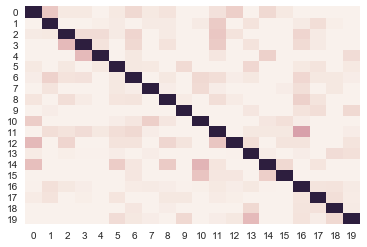

In [8]:
'''
Read well-trained models and find the one with best score
'''
from hmmlearn import hmm
from sklearn.externals import joblib
import glob
import warnings
import seaborn as sns

def fxn():
    warnings.warn("deprecated", DeprecationWarning)


    
model_path = 'GMMHMM_models/*.pkl'
files = glob.glob(model_path)
bset_model = []
max_score = -1e10
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for name in files:
        gmm_hmm = joblib.load(name)
        print("Model name: ", name)
        print("score:", gmm_hmm.score(X, length))
        if gmm_hmm.score(X, length) > max_score:
            max_score = gmm_hmm.score(X, length)
            best_model = gmm_hmm
#     test = data_segments[251]
#     z = best_model.predict(test)
#     print ("predicted state: ", z)
#     plt.figure(2)
#     plt.plot(test)
#     test = data_segments[12]
#     z = best_model.predict(test)
#     print ("predicted state: ", z)
#     plt.figure(3)
#     plt.plot(test)
plt.figure(1)
sns.heatmap(best_model.transmat_,vmin=0, vmax=0.05, cbar=False)
plt.show

In [9]:
def gaussian_prob(x, mu,sigma):
    diff = np.reshape((x-mu),(1,len(x)))
    log_prob = (-1/2) * np.dot(np.dot(diff, np.linalg.pinv(sigma)), diff.T) - np.log(np.sqrt(np.linalg.det(2*np.pi*sigma)))
    return float(np.exp(log_prob))

predicted state:  [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 14 14 14 14 14 14 14 14 14 14  0  0  0  0  0  0]
beta:  [  1.02860086e-053   9.89274241e-155   2.61299437e-047   5.88327810e-032
   1.30233476e-058   1.39741071e-004   1.86286019e-022   4.03053979e-054
   7.32037910e-029   4.42144031e-009   7.86594843e-084   4.25080216e-009
   4.55182198e-016   2.35854240e-026   2.15767648e-030   3.57848583e-001
   3.67369136e-001   2.74598035e-001   5.66083375e-044   4.44951114e-005]


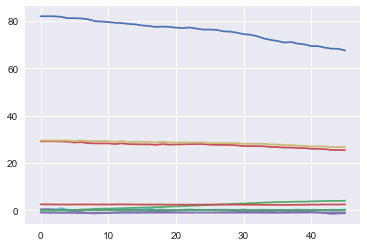

In [18]:
'''
run predict using well-trained model
So far the hiddent variable is data[:,5] (accel) and data[:,7] (yaw rate)

Observable data: {dx, dy, dv, v_ego, yaw_angle, velocity, d_l, d_r}
Predict data: {acceleration, yaw_rate}
'''
observable_col = [0,1,2,3,4,6,8,9]
hidden_col = [5,7]
test = data_segments[254]
test_obs = test[:,observable_col] # observable variable
test_hidden = test[:,hidden_col] # hidden variable
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    # use build-in predictor to predict
    z = best_model.predict(test)
    print ("predicted state: ", z)
    plt.figure(1)
    plt.plot(test)
    
    
    A = best_model.transmat_
 
    x0 = test_obs[0,:]
    num = []
    den = 0
    for gmm in best_model.gmms_:
        omega = gmm.weights_
        prob = 0
        for m in range(gmm.means_.shape[0]):
            mu = gmm.means_[m,observable_col]
            sigma = np.diag(gmm.covars_[m, observable_col])
            prob += omega[m] * gaussian_prob(x0, mu, sigma)
        num.append(prob)
    beta = np.array(num)/np.sum(num) # beta is (k,)
    print ("beta: ", beta)

In [24]:
    # compute the mean of mu and sigma for each state
    mu_mean_list = []
    sigma_mean_list = []
    for gmm in best_model.gmms_:
        mu_mean_list.append(np.mean(gmm.means_,axis=0))
        sigma_mean_list.append(np.mean(gmm.covars_, axis=0))
    mu_mean_list = np.array(mu_mean_list)[:,observable_col]
    sigma_mean_list = np.array(sigma_mean_list)[:,observable_col]
    

(20, 8)
(20, 8)


predicted state:  [12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 11 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14]
[[  2.39048202e+01   1.76275536e+00   8.68742366e+00   9.18195389e-03
    9.40821808e+00  -9.67542539e-04   1.94341433e+00  -1.45483125e+00]
 [  4.44278269e+01   4.17353372e+00   2.56673222e+01  -1.21604608e+00
    2.66840423e+01   1.62378054e-03   2.42350378e+00  -9.61011423e-01]
 [  9.31708719e+01   6.13601385e+00   2.08125852e+01  -1.52941277e-01
    2.13327780e+01  -5.71948525e-03   3.13632388e+00  -4.49989452e-01]
 [  7.40194263e+01   4.52778185e+00  -1.16088115e+00   7.78001216e-01
    4.99998691e-01   9.43358553e-02   1.71111041e+00  -1.57066673e+00]
 [  2.33606151e+01  -1.64526354e+00   1.80534377e+01  -6.56746090e-02
    1.86056886e+01  -3.86685866e-02   2.15347650e+00  -1.83756806e+00]]


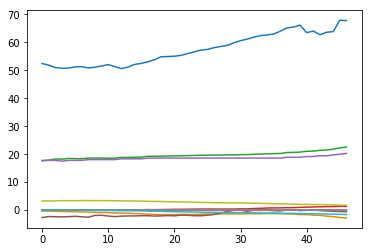

In [46]:
    for t in range(1,test.shape[0]):
        beta_num = []
        x = test_obs[t,:]
        for k, gmm in enumerate(best_mode.gmms_):
            omega = gmm.weights_
            prob = 0
            for m in gmm.means_.shape[0]:
                mu = gmm.means_[m,observable_col]
                sigma = np.diagnal(gmm.covars_[m,observable_col])
                prob += omega[m]*gaussian(x,best_model.gmms_[0].means)
            beta_num.append(np.sum(beta * A[:,k]) * prob)
        beta = beta_num/np.sum(beta_num)
        
        np.dot(beta,mu_mean_list)
        